In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (1460, 81)
Test shape: (1459, 80)


In [2]:
y_train = train['SalePrice'].copy()
train_ids = train['Id'].copy()        
test_ids = test['Id'].copy()

train_no_target = train.drop(['SalePrice', 'Id'], axis=1).copy()
test_no_id = test.drop('Id', axis=1).copy()

print(f"\\nКолонки в train, но не в test:", set(train_no_target.columns) - set(test_no_id.columns))

\nКолонки в train, но не в test: set()


In [3]:
print("\nКолонки в train, но не в test:", set(train.columns) - set(test.columns))  
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()
diff = (missing_test > 0) & (missing_train == 0)
print("\nКолонки с пропусками в test, но без пропусков в train:", list(diff[diff].index))

cat_cols = train.select_dtypes(include='object').columns
for col in cat_cols:
    train_vals = set(train[col].dropna().unique())
    test_vals = set(test[col].dropna().unique())
    if test_vals - train_vals:
        print(f"{col}: в test есть значения, которых нет в train: {test_vals - train_vals}")


Колонки в train, но не в test: {'SalePrice'}

Колонки с пропусками в test, но без пропусков в train: ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'Exterior1st', 'Exterior2nd', 'Functional', 'GarageArea', 'GarageCars', 'KitchenQual', 'MSZoning', 'SaleType', 'TotalBsmtSF', 'Utilities']


In [4]:
all_data = pd.concat([train_no_target, test_no_id], ignore_index=True)
print(f"Объединенный датасет: {all_data.shape}")

Объединенный датасет: (2919, 79)


In [5]:
cat_cols =['Alley', 'BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 
                'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']

In [6]:
for col in cat_cols:
    all_data[col] = all_data[col].fillna('without')

In [7]:
all_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,without,Reg,Lvl,AllPub,Inside,...,0,0,without,without,without,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,without,Reg,Lvl,AllPub,FR2,...,0,0,without,without,without,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,without,IR1,Lvl,AllPub,Inside,...,0,0,without,without,without,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,without,IR1,Lvl,AllPub,Corner,...,0,0,without,without,without,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,without,IR1,Lvl,AllPub,FR2,...,0,0,without,without,without,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,without,Reg,Lvl,AllPub,Inside,...,0,0,without,without,without,0,6,2006,WD,Normal
2915,160,RM,21.0,1894,Pave,without,Reg,Lvl,AllPub,Inside,...,0,0,without,without,without,0,4,2006,WD,Abnorml
2916,20,RL,160.0,20000,Pave,without,Reg,Lvl,AllPub,Inside,...,0,0,without,without,without,0,9,2006,WD,Abnorml
2917,85,RL,62.0,10441,Pave,without,Reg,Lvl,AllPub,Inside,...,0,0,without,MnPrv,Shed,700,7,2006,WD,Normal


In [8]:
print(all_data.isnull().sum()[all_data.isnull().sum() > 0])

MSZoning          4
LotFrontage     486
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
Electrical        1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
GarageYrBlt     159
GarageCars        1
GarageArea        1
SaleType          1
dtype: int64


In [9]:
def handle_all_missing_values(df):
    numeric_zero_cols = [
        'MasVnrArea', 
        'GarageArea',  
        'GarageCars',    
        'BsmtFinSF1',      
        'BsmtFinSF2',      
        'BsmtUnfSF',       
        'TotalBsmtSF',    
        'BsmtFullBath',   
        'BsmtHalfBath'     
    ]
    
    for col in numeric_zero_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    
    # 2. Категориальные: NaN = "None" (отсутствие объекта)
    none_categorical_cols = [
        'Alley',         
        'BsmtQual',       
        'BsmtCond',        
        'BsmtExposure',    
        'BsmtFinType1',    
        'BsmtFinType2',    
        'FireplaceQu',     
        'GarageType',      
        'GarageFinish',    
        'GarageQual',      
        'GarageCond',      
        'PoolQC',         
        'Fence',          
        'MiscFeature',     
        'MasVnrType'       
    ]
    
    for col in none_categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna('without')
    
    # 3. Особые случаи
    
    if 'LotFrontage' in df.columns:
        df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage']\
                              .transform(lambda x: x.fillna(x.median()))
        if df['LotFrontage'].isna().any():
            df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
    if 'GarageYrBlt' in df.columns:
        df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

        if 'YearBuilt' in df.columns:
            mask = df['GarageYrBlt'] == 0
            df.loc[mask, 'GarageYrBlt'] = df.loc[mask, 'YearBuilt']
    
    if 'Electrical' in df.columns:
        df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].mode()[0])
    
    return df

all_data = handle_all_missing_values(all_data)
missing_after = all_data.isnull().sum()
remaining_nans = missing_after[missing_after > 0]

if len(remaining_nans) == 0:
    print("✅ Все пропуски успешно обработаны!")
    print(f"Размер данных: {all_data.shape}")
else:
    print(f"⚠️ Осталось {len(remaining_nans)} колонок с пропусками:")
    for col, count in remaining_nans.items():
        print(f"  {col}: {count} пропусков")

✅ Все пропуски успешно обработаны!
Размер данных: (2919, 79)


In [10]:
X_train_processed = all_data.iloc[:len(train_no_target)].copy()
X_test_processed = all_data.iloc[len(train_no_target):].copy()
X_train_processed['SalePrice'] = y_train.values
X_train_processed['Id'] = train_ids.values
X_test_processed['Id'] = test_ids.values

X_train_processed = X_train_processed.assign(SalePrice=y_train.values, Id=train_ids.values)
X_test_processed = X_test_processed.assign(Id=test_ids.values)

print(f"\nTrain shape после обработки: {X_train_processed.shape}")
print(f"Test shape после обработки: {X_test_processed.shape}")

train_nans = X_train_processed.drop('SalePrice', axis=1).isnull().sum().sum()
test_nans = X_test_processed.isnull().sum().sum()
print(f"\nПропуски в train (без SalePrice): {train_nans}")
print(f"Пропуски в test: {test_nans}")


Train shape после обработки: (1460, 81)
Test shape после обработки: (1459, 80)

Пропуски в train (без SalePrice): 0
Пропуски в test: 0


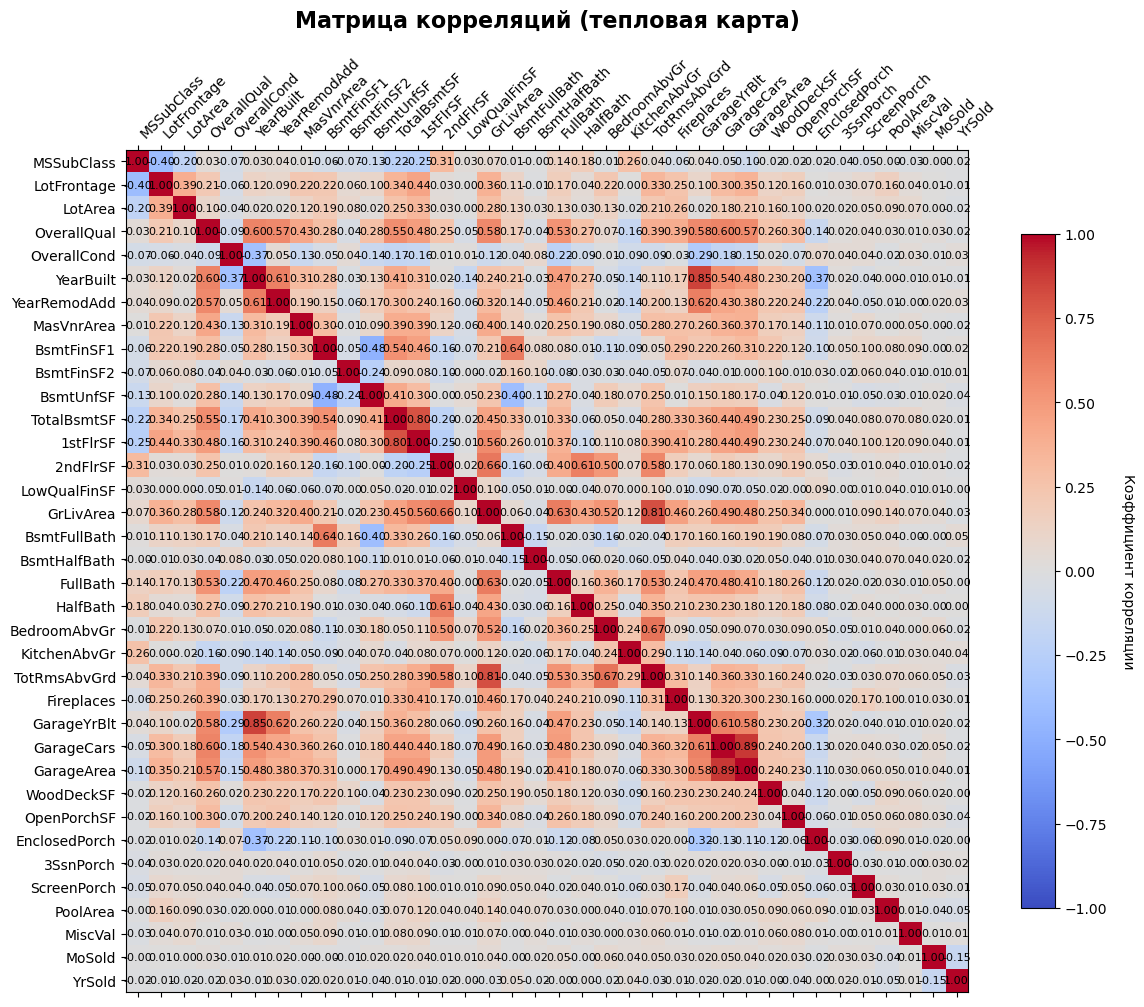

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Вычисляем корреляционную матрицу
corr_matrix = all_data.select_dtypes(include=[np.number]).corr()

# Создаём фигуру и оси
fig, ax = plt.subplots(figsize=(12, 10))


# Рисуем тепловую карту через matshow
im = ax.matshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)


# Добавляем значения корреляций в ячейки
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                ha='center', va='center', color='black', fontsize=8)


# Настраиваем метки
ax.set_xticks(range(corr_matrix.shape[1]))
ax.set_yticks(range(corr_matrix.shape[0]))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='left')
ax.set_yticklabels(corr_matrix.columns)


# Добавляем цветную шкалу (легенду)
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Коэффициент корреляции', rotation=270, labelpad=20)


# Заголовок
plt.title('Матрица корреляций (тепловая карта)', fontsize=16, fontweight='bold', pad=20)


# Улучшаем расположение элементов
plt.tight_layout()
plt.show()

Результат:
Overquality очень хорошо предсказывает таргет
Garageyearbuild на 85 проц повторяет Yearbuild
Total bsmtSF кандидат на выкид - колинеарный с площадьми первого этажа и пр
totalrmsabvgrd выкидываем так как отражает жилую площадь без подвала
Garage cars выкинуть отражает garage area

📊 Начинаем визуализацию...
\n1. Анализ целевой переменной SalePrice...


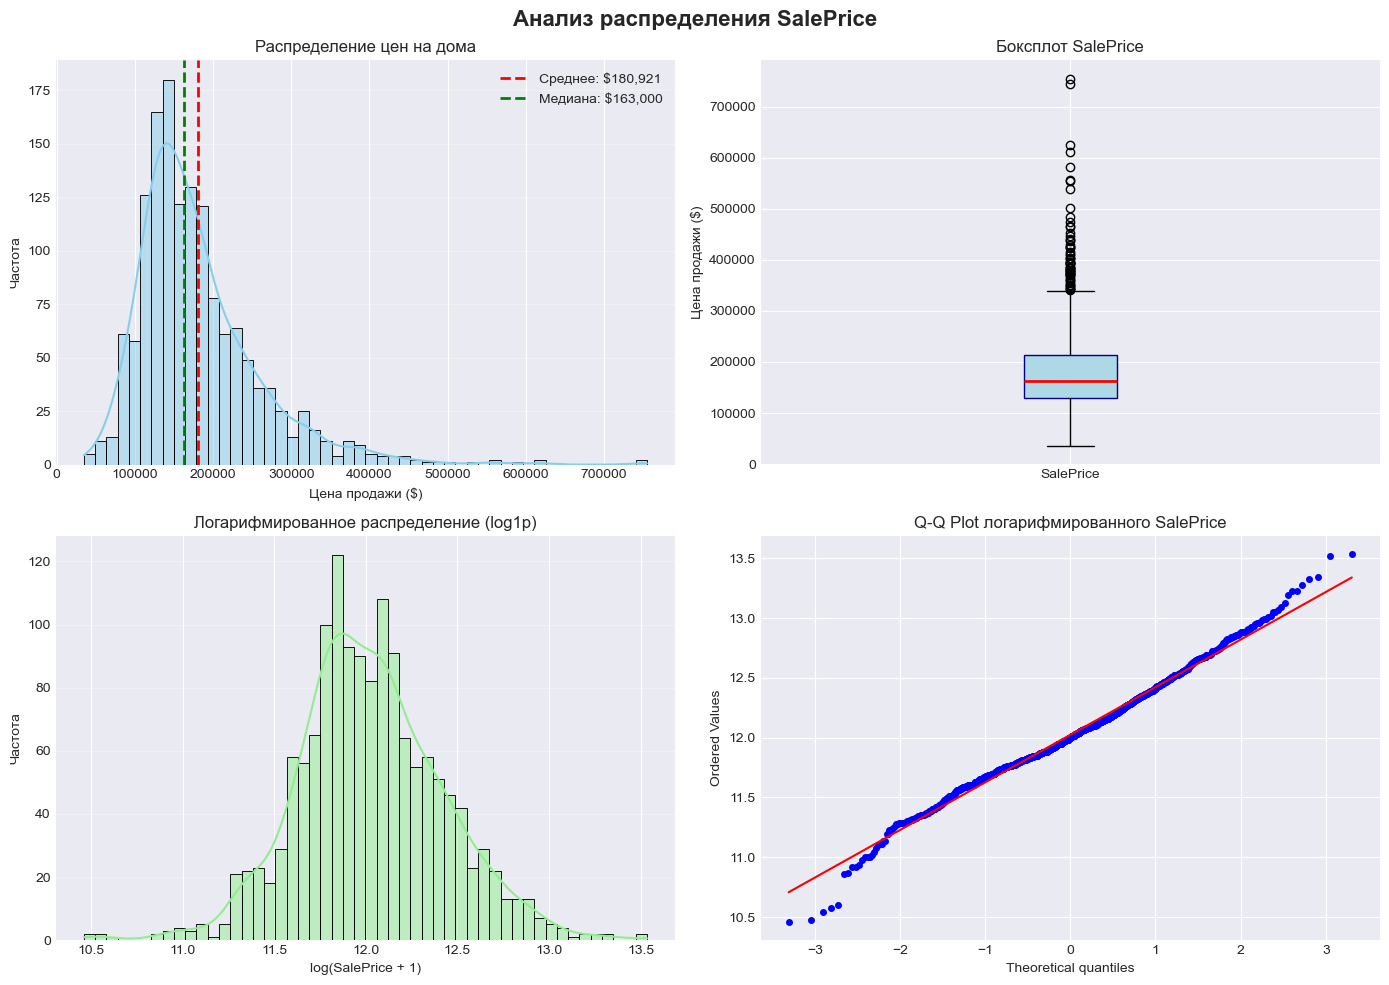

📈 Статистика SalePrice:
   • Минимальная цена: $34,900
   • Максимальная цена: $755,000
   • Средняя цена: $180,921
   • Медианная цена: $163,000
   • Стандартное отклонение: $79,443
   • Коэффициент вариации: 43.9%
\n2. Анализ числовых признаков...


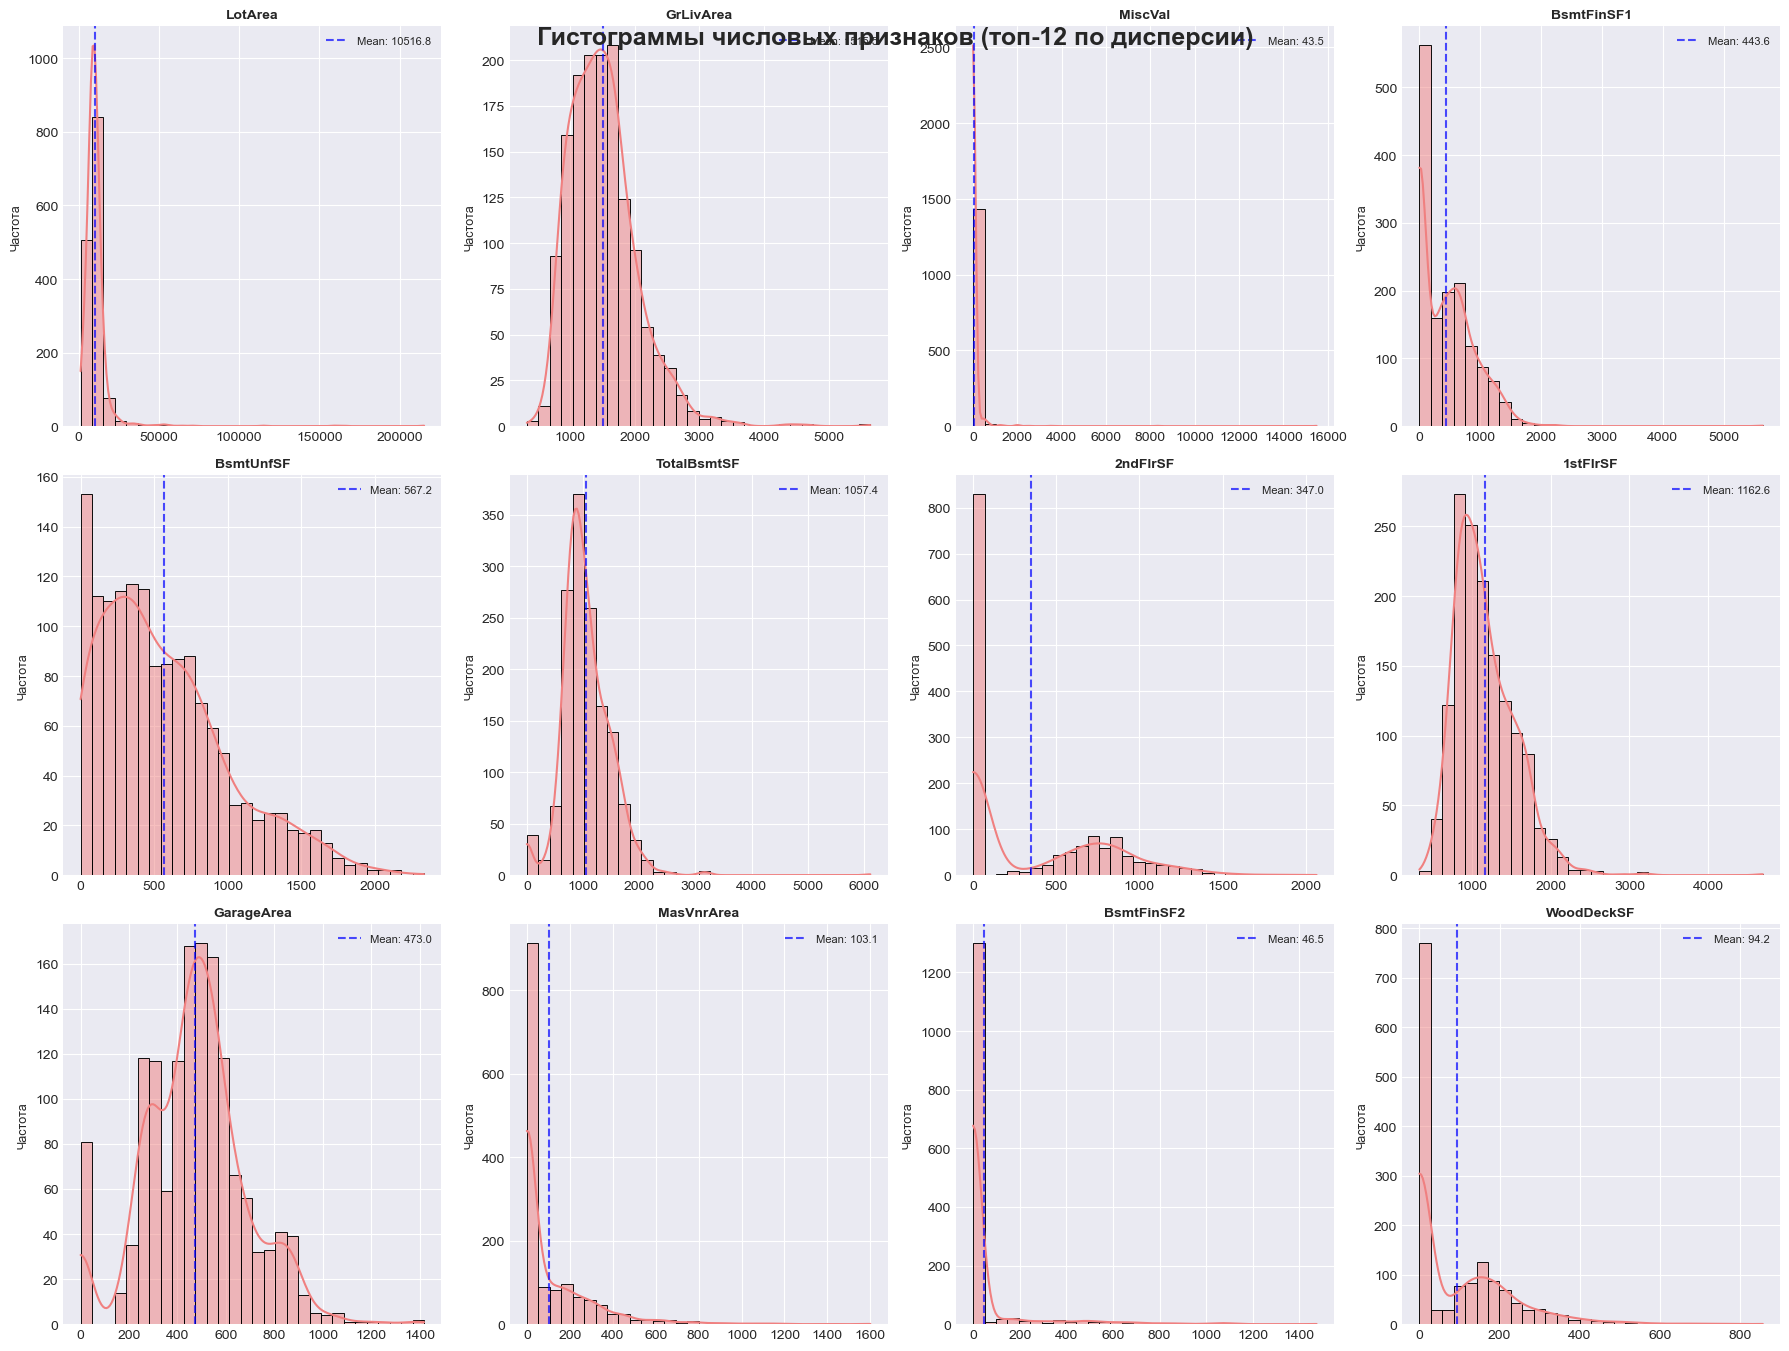

\n3. Анализ категориальных признаков...


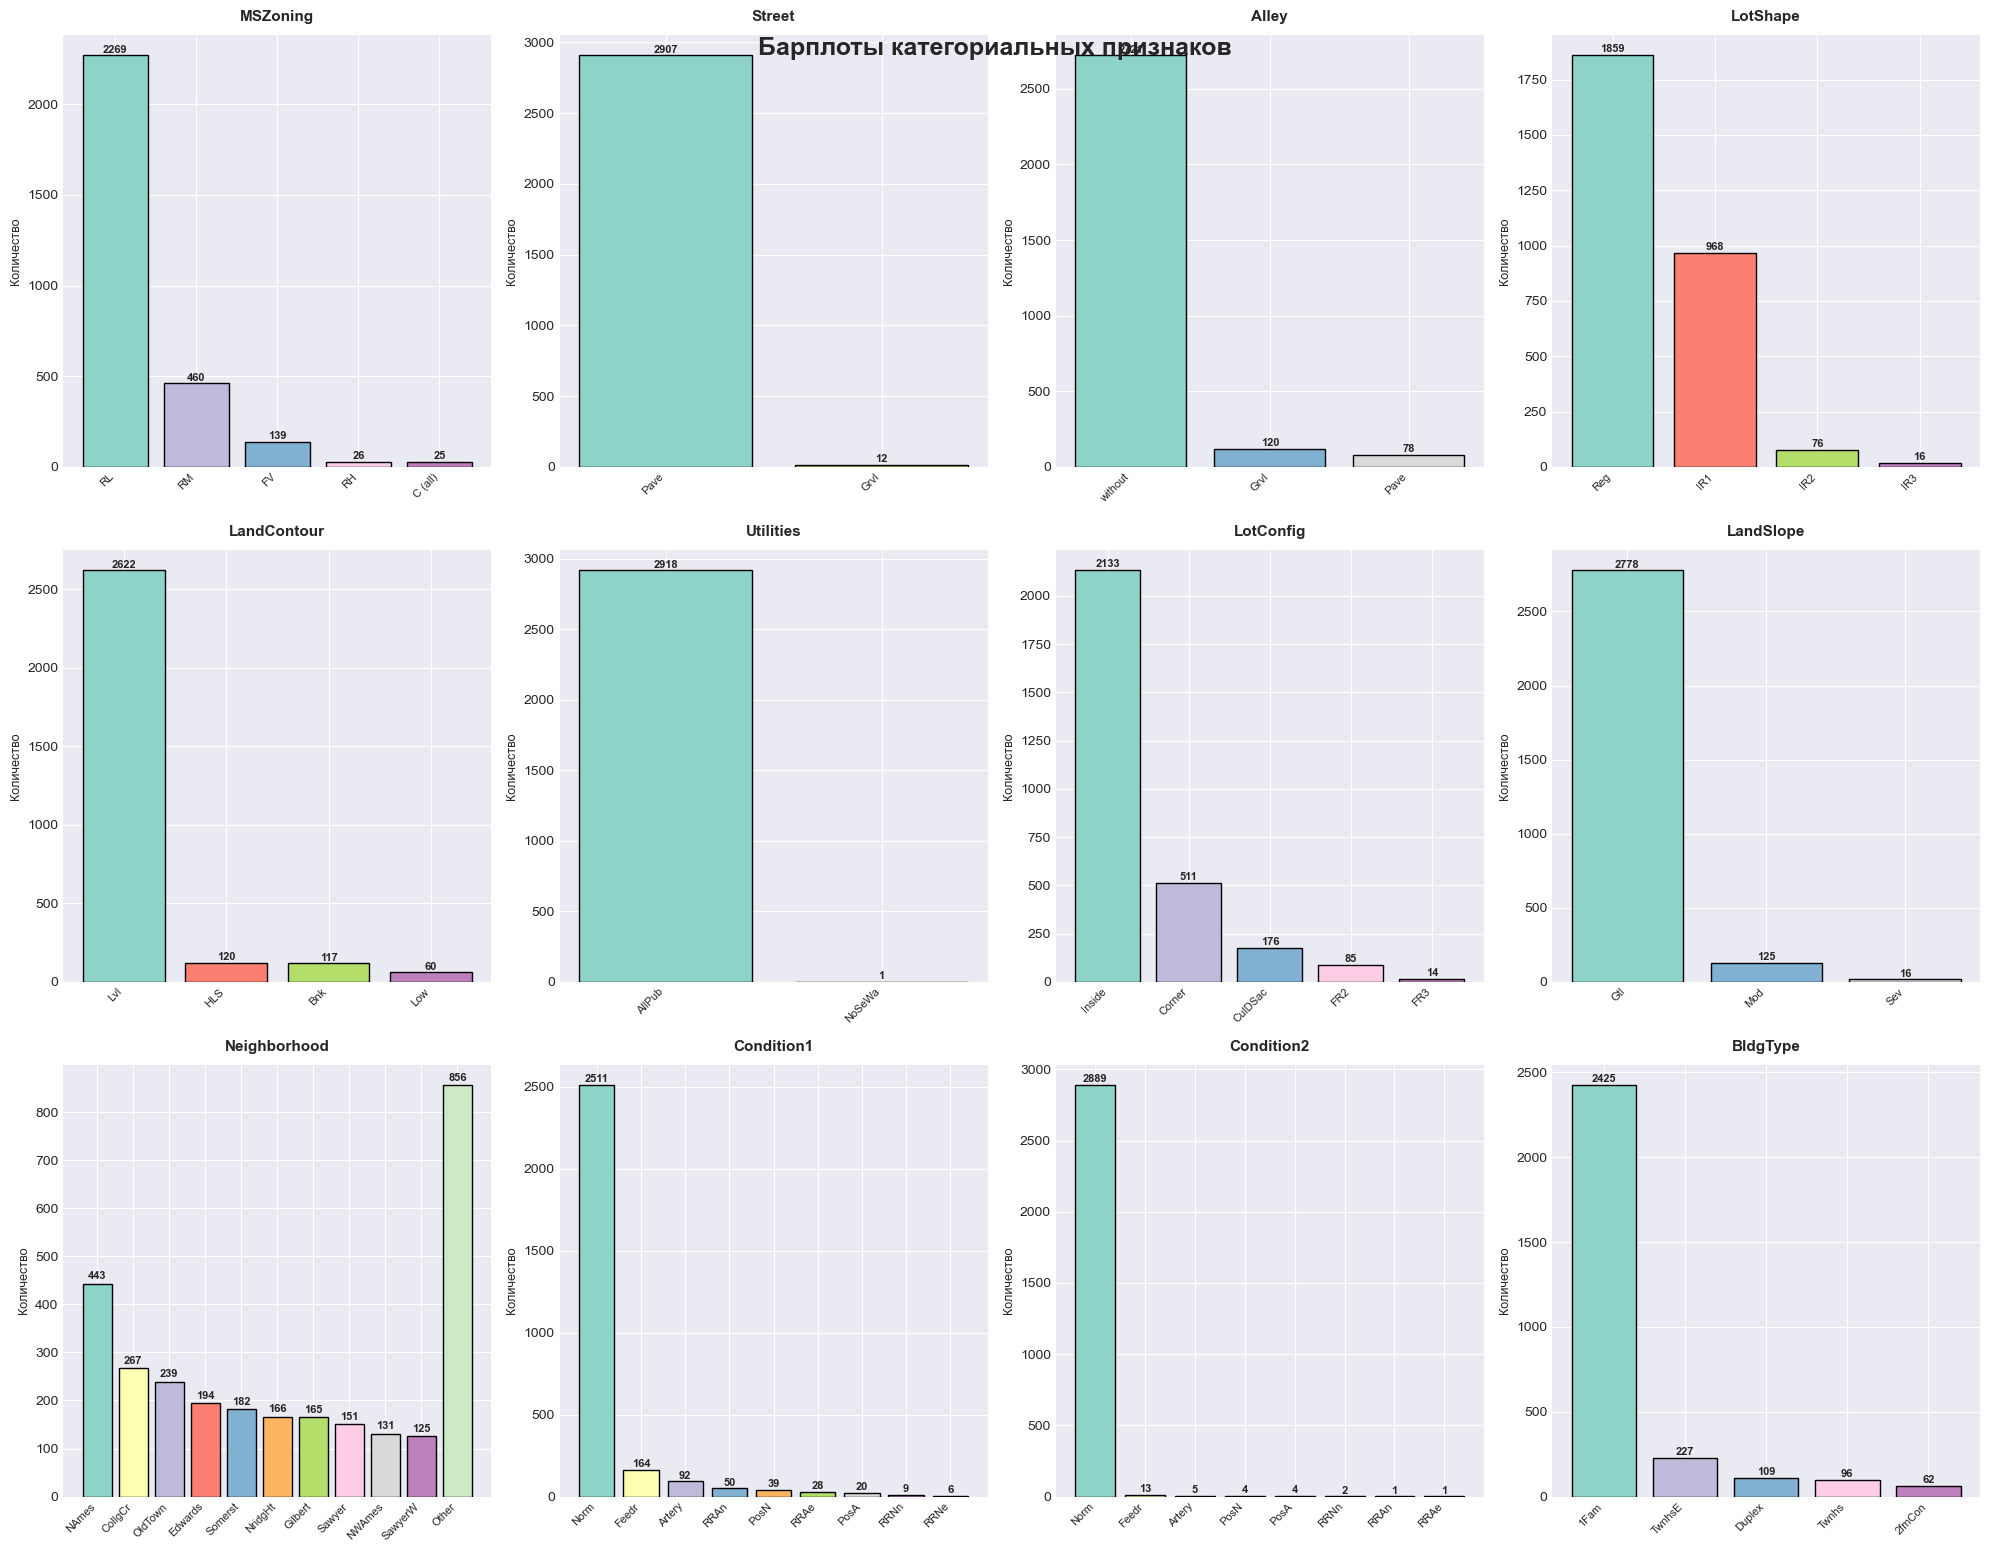

\n4. Анализ корреляций...


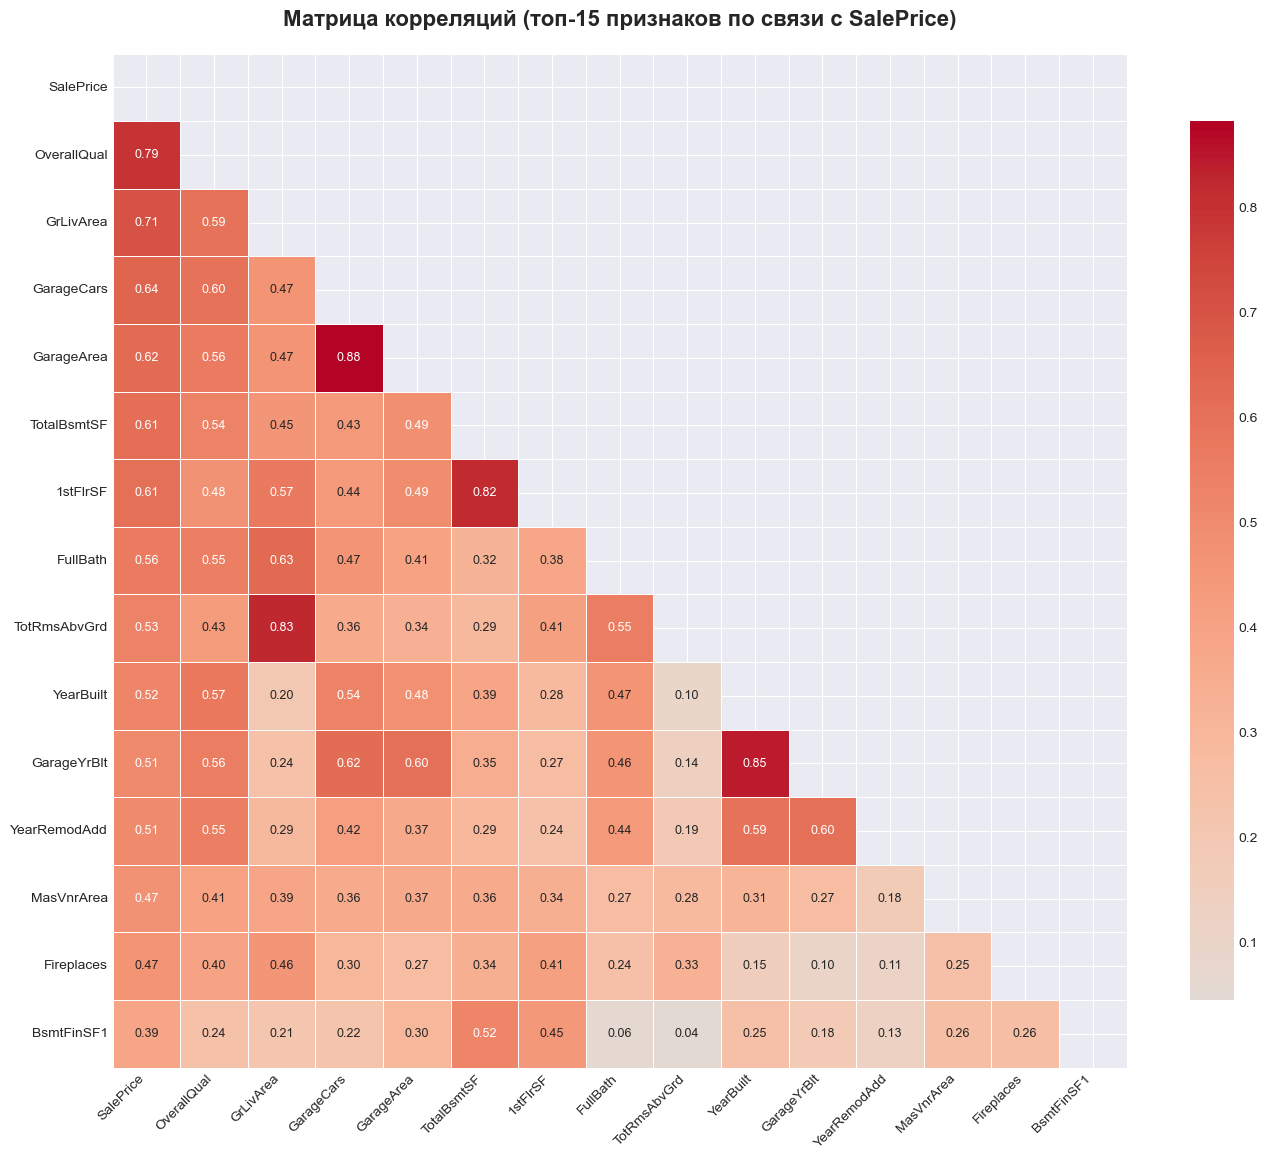

🔝 ТОП-10 признаков по корреляции с SalePrice:
 2. OverallQual          | Корреляция: +0.791
 3. GrLivArea            | Корреляция: +0.709
 4. GarageCars           | Корреляция: +0.640
 5. GarageArea           | Корреляция: +0.623
 6. TotalBsmtSF          | Корреляция: +0.614
 7. 1stFlrSF             | Корреляция: +0.606
 8. FullBath             | Корреляция: +0.561
 9. TotRmsAbvGrd         | Корреляция: +0.534
10. YearBuilt            | Корреляция: +0.523
\n5. Анализ взаимосвязей...


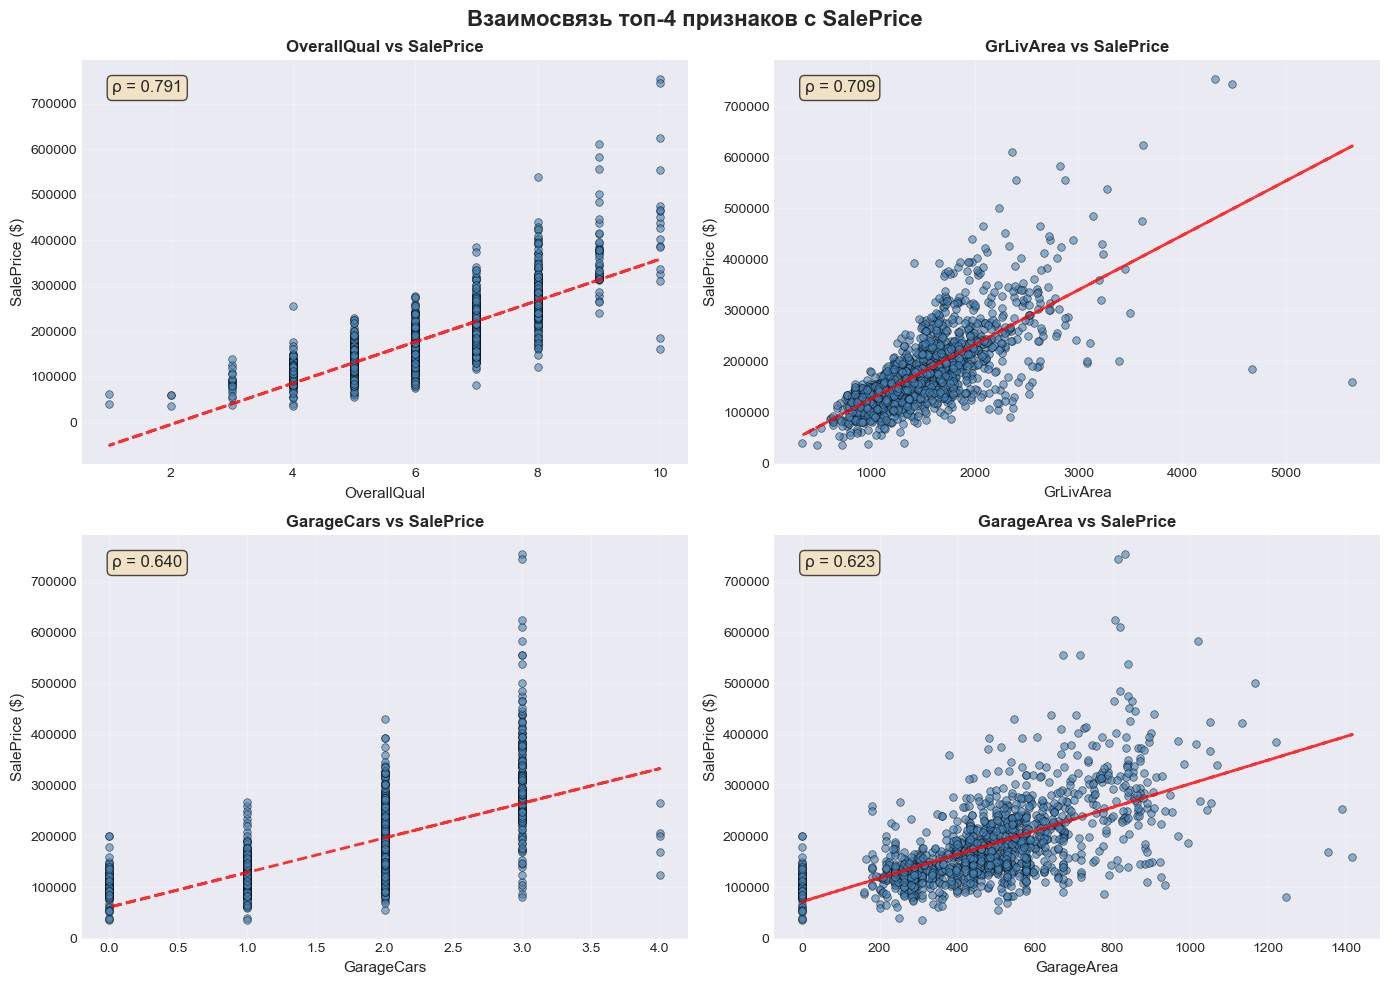

\n✅ Визуализация успешно завершена!


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("📊 Начинаем визуализацию...")

# Используем X_train_processed, так как там есть SalePrice
data_for_viz = X_train_processed.copy()

# 1. РАСПРЕДЕЛЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (ЦЕНЫ НА ДОМА)
print("\\n1. Анализ целевой переменной SalePrice...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Анализ распределения SalePrice', fontsize=16, fontweight='bold')

# Гистограмма с ядром плотности
ax1 = axes[0, 0]
sns.histplot(data_for_viz['SalePrice'], kde=True, color='skyblue', ax=ax1, bins=50)
ax1.set_title('Распределение цен на дома')
ax1.set_xlabel('Цена продажи ($)')
ax1.set_ylabel('Частота')
ax1.grid(axis='y', alpha=0.3)

# Добавляем статистики
mean_price = data_for_viz['SalePrice'].mean()
median_price = data_for_viz['SalePrice'].median()
ax1.axvline(mean_price, color='red', linestyle='--', linewidth=2, label=f'Среднее: ${mean_price:,.0f}')
ax1.axvline(median_price, color='green', linestyle='--', linewidth=2, label=f'Медиана: ${median_price:,.0f}')
ax1.legend()

# Боксплот
ax2 = axes[0, 1]
box_data = [data_for_viz['SalePrice']]
ax2.boxplot(box_data, vert=True, patch_artist=True, 
           boxprops=dict(facecolor='lightblue', color='darkblue'),
           medianprops=dict(color='red', linewidth=2))
ax2.set_title('Боксплот SalePrice')
ax2.set_ylabel('Цена продажи ($)')
ax2.set_xticklabels(['SalePrice'])

# Логарифмированное распределение
ax3 = axes[1, 0]
log_price = np.log1p(data_for_viz['SalePrice'])
sns.histplot(log_price, kde=True, color='lightgreen', ax=ax3, bins=50)
ax3.set_title('Логарифмированное распределение (log1p)')
ax3.set_xlabel('log(SalePrice + 1)')
ax3.set_ylabel('Частота')
ax3.grid(axis='y', alpha=0.3)

# Q-Q plot для проверки нормальности логарифмированных данных
ax4 = axes[1, 1]
stats.probplot(log_price, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot логарифмированного SalePrice')
ax4.get_lines()[0].set_markerfacecolor('blue')
ax4.get_lines()[0].set_markersize(4)

plt.tight_layout()
plt.show()

# Вывод статистик
print(f"📈 Статистика SalePrice:")
print(f"   • Минимальная цена: ${data_for_viz['SalePrice'].min():,.0f}")
print(f"   • Максимальная цена: ${data_for_viz['SalePrice'].max():,.0f}")
print(f"   • Средняя цена: ${mean_price:,.0f}")
print(f"   • Медианная цена: ${median_price:,.0f}")
print(f"   • Стандартное отклонение: ${data_for_viz['SalePrice'].std():,.0f}")
print(f"   • Коэффициент вариации: {(data_for_viz['SalePrice'].std() / mean_price * 100):.1f}%")

# 2. САБПЛОТ С ГИСТОГРАММАМИ ЧИСЛОВЫХ ПРИЗНАКОВ
print("\\n2. Анализ числовых признаков...")

# Удаляем Id и SalePrice из числовых признаков для анализа
numeric_cols = data_for_viz.select_dtypes(include=[np.number]).columns.tolist()

# Удаляем неинформативные колонки
columns_to_remove = ['Id', 'SalePrice']
numeric_cols = [col for col in numeric_cols if col not in columns_to_remove]

# Ограничиваем число признаков для наглядности (первые 12 наиболее важных)
# Сначала выберем признаки с наибольшей дисперсией
numeric_data = data_for_viz[numeric_cols]
variances = numeric_data.var().sort_values(ascending=False)
top_numeric_cols = variances.head(12).index.tolist()

if len(top_numeric_cols) > 0:
    fig, axes = plt.subplots(3, 4, figsize=(18, 14))
    axes = axes.ravel()
    
    for i, col in enumerate(top_numeric_cols):
        if i < len(axes):
            ax = axes[i]
            # Гистограмма с ядром плотности
            sns.histplot(data_for_viz[col].dropna(), ax=ax, color='lightcoral', kde=True, bins=30)
            ax.set_title(f'{col}', fontsize=10, fontweight='bold')
            ax.set_xlabel('')
            ax.set_ylabel('Частота', fontsize=9)
            
            # Добавляем вертикальную линию для среднего
            mean_val = data_for_viz[col].mean()
            ax.axvline(mean_val, color='blue', linestyle='--', alpha=0.7, 
                      linewidth=1.5, label=f'Mean: {mean_val:.1f}')
            ax.legend(fontsize=8)
    
    # Удаляем пустые подграфики
    for j in range(len(top_numeric_cols), len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle('Гистограммы числовых признаков (топ-12 по дисперсии)', 
                 fontsize=18, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Не найдено числовых признаков для визуализации.")

# 3. САБПЛОТ С БАРПЛОТАМИ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
print("\\n3. Анализ категориальных признаков...")

# Используем all_data (обработанные данные без SalePrice и Id)
categorical_cols = all_data.select_dtypes(include=['object']).columns.tolist()

if len(categorical_cols) > 0:
    # Выбираем первые 12 категориальных признаков
    categorical_cols = categorical_cols[:12]
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 16))
    axes = axes.ravel()
    
    for i, col in enumerate(categorical_cols):
        if i < len(axes):
            ax = axes[i]
            
            # Считаем частоты категорий
            counts = all_data[col].value_counts()
            
            # Если категорий слишком много, показываем топ-10
            if len(counts) > 10:
                top_counts = counts.head(10)
                other_count = counts[10:].sum()
                if other_count > 0:
                    top_counts = pd.concat([top_counts, pd.Series({'Other': other_count})])
                counts = top_counts
            
            # Создаем барплот
            colors = plt.cm.Set3(np.arange(len(counts)) / len(counts))
            bars = ax.bar(range(len(counts)), counts.values, color=colors, edgecolor='black')
            
            ax.set_title(f'{col}', fontsize=11, fontweight='bold', pad=10)
            ax.set_xlabel('')
            ax.set_ylabel('Количество', fontsize=9)
            
            # Настройка подписей на оси X
            ax.set_xticks(range(len(counts)))
            labels = [str(label)[:15] + '...' if len(str(label)) > 15 else str(label) 
                     for label in counts.index]
            ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
            
            # Добавляем значения на столбцы
            for bar, count in zip(bars, counts.values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                       f'{count}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # Удаляем пустые подграфики
    for j in range(len(categorical_cols), len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle('Барплоты категориальных признаков', fontsize=18, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Не найдено категориальных признаков для визуализации.")

# 4. МАТРИЦА КОРРЕЛЯЦИЙ (ТЕПЛОВАЯ КАРТА)
print("\\n4. Анализ корреляций...")

# Для корреляции используем только числовые признаки из обучающих данных
corr_data = data_for_viz.select_dtypes(include=[np.number])

# Удаляем Id (он не имеет смысла для корреляции)
if 'Id' in corr_data.columns:
    corr_data = corr_data.drop('Id', axis=1)

# Ограничим размер матрицы для лучшей читаемости
# Возьмем топ-15 признаков по корреляции с SalePrice
if 'SalePrice' in corr_data.columns:
    # Вычисляем корреляции с SalePrice
    corr_with_target = corr_data.corr()['SalePrice'].abs().sort_values(ascending=False)
    
    # Выбираем топ-15 признаков (включая SalePrice)
    top_features = corr_with_target.head(15).index.tolist()
    
    if len(top_features) > 1:
        corr_matrix = corr_data[top_features].corr()
        
        # Создаем тепловую карту
        plt.figure(figsize=(14, 12))
        
        # Маска для верхнего треугольника
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        # Тепловая карта с аннотациями
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
                   cmap='coolwarm', center=0, square=True, 
                   linewidths=.5, cbar_kws={"shrink": .8},
                   annot_kws={"size": 9})
        
        plt.title('Матрица корреляций (топ-15 признаков по связи с SalePrice)', 
                 fontsize=16, fontweight='bold', pad=20)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # Выводим топ-10 признаков по корреляции с SalePrice
        print("🔝 ТОП-10 признаков по корреляции с SalePrice:")
        for i, (feature, corr) in enumerate(corr_with_target.items(), 1):
            if feature != 'SalePrice' and i <= 10:
                correlation = corr_data.corr().loc[feature, 'SalePrice']
                print(f"{i:2}. {feature:20} | Корреляция: {correlation:+.3f}")
    else:
        print("⚠️ Недостаточно признаков для построения матрицы корреляций.")
else:
    print("⚠️ SalePrice не найден в данных для корреляции.")

# 5. ДОПОЛНИТЕЛЬНО: ВЗАИМОСВЯЗЬ ТОП-4 ПРИЗНАКОВ С SALEPRICE
print("\\n5. Анализ взаимосвязей...")

if 'SalePrice' in data_for_viz.columns and len(corr_with_target) > 4:
    # Выбираем топ-4 признака по абсолютной корреляции (исключая SalePrice)
    top_features = corr_with_target.index[1:5]  # пропускаем SalePrice
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()
    
    for i, feature in enumerate(top_features):
        if i < len(axes):
            ax = axes[i]
            
            # Рассеянный график
            scatter = ax.scatter(data_for_viz[feature], data_for_viz['SalePrice'], 
                                alpha=0.6, s=30, edgecolor='black', linewidth=0.5,
                                c='steelblue')
            
            # Линия регрессии
            z = np.polyfit(data_for_viz[feature], data_for_viz['SalePrice'], 1)
            p = np.poly1d(z)
            ax.plot(data_for_viz[feature], p(data_for_viz[feature]), 
                   "r--", alpha=0.8, linewidth=2)
            
            ax.set_xlabel(feature, fontsize=11)
            ax.set_ylabel('SalePrice ($)', fontsize=11)
            ax.set_title(f'{feature} vs SalePrice', fontsize=12, fontweight='bold')
            
            # Добавляем коэффициент корреляции
            corr = corr_data.corr().loc[feature, 'SalePrice']
            ax.text(0.05, 0.95, f'ρ = {corr:.3f}', transform=ax.transAxes,
                   fontsize=12, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
            
            # Сетка
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('Взаимосвязь топ-4 признаков с SalePrice', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

print("\\n✅ Визуализация успешно завершена!")

In [13]:
X_train = X_train_processed.drop(['Id', 'SalePrice'], axis=1).copy()
y_train = X_train_processed['SalePrice'].copy()
X_test = X_test_processed.drop('Id', axis=1).copy()
test_ids = X_test_processed['Id'].copy()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(1460, 79)
(1460,)
(1459, 79)


In [14]:
y_train_log = np.log1p(y_train)
print(f"   Исходный SalePrice: [{y_train.min():,.0f}, {y_train.max():,.0f}]")
print(f"   Логарифмированный: [{y_train_log.min():.2f}, {y_train_log.max():.2f}]")

   Исходный SalePrice: [34,900, 755,000]
   Логарифмированный: [10.46, 13.53]


In [15]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_log, test_size=0.2, random_state=42
)
print(f"   Train split: {X_train_split.shape}")
print(f"   Val split: {X_val_split.shape}")

   Train split: (1168, 79)
   Val split: (292, 79)


In [16]:
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"   Числовых признаков: {len(numeric_cols)}")
print(f"   Категориальных признаков: {len(categorical_cols)}")

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

   Числовых признаков: 36
   Категориальных признаков: 43


In [17]:
numeric_transformer

,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [18]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [19]:
categorical_transformer

,steps,"[('imputer', ...), ('onehot', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'constant'
,fill_value,'missing'
,copy,True
,add_indicator,False
,keep_empty_features,False
,categories,'auto'


In [20]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [21]:
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [22]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [23]:
pipeline.fit(X_train_split, y_train_split)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [24]:
y_val_pred_log = pipeline.predict(X_val_split)
y_val_pred = np.expm1(y_val_pred_log)
y_val_true = np.expm1(y_val_split)
print("📊 Статистика предсказаний на валидации:")
print(f"Фактические:  мин=${y_val_true.min():,.0f}, макс=${y_val_true.max():,.0f}, среднее=${y_val_true.mean():,.0f}")
print(f"Предсказанные: мин=${y_val_pred.min():,.0f}, макс=${y_val_pred.max():,.0f}, среднее=${y_val_pred.mean():,.0f}")

print("\\nПервые 5 значений:")
for i, (actual, predicted) in enumerate(zip(list(y_val_true)[:5], y_val_pred[:5])):
    print(f"  {i}: ${actual:,.0f} -> ${predicted:,.0f}")

📊 Статистика предсказаний на валидации:
Фактические:  мин=$35,311, макс=$755,000, среднее=$178,840
Предсказанные: мин=$44,023, макс=$768,135, среднее=$178,283
\nПервые 5 значений:
  0: $154,500 -> $153,384
  1: $325,000 -> $341,099
  2: $115,000 -> $100,332
  3: $159,000 -> $165,153
  4: $315,500 -> $311,321


In [25]:
mse = mean_squared_error(y_val_true, y_val_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_val_true - y_val_pred))

In [26]:
print(f"MSE: {mse:,.2f}")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAE: ${mae:,.2f}")

MSE: 527,197,795.06
RMSE: $22,960.79
MAE: $15,138.33


In [27]:
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

rmsle_score = rmsle(y_val_true, y_val_pred)
print(f"   RMSLE: {rmsle_score:.4f}")

   RMSLE: 0.1325


In [28]:
pipeline.fit(X_train, y_train_log)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [29]:
y_test_pred_log = pipeline.predict(X_test)
y_test_pred = np.expm1(y_test_pred_log)

In [30]:
print(f"   Предсказано значений: {len(y_test_pred)}")
print(f"   Диапазон предсказаний: [${y_test_pred.min():,.0f}, ${y_test_pred.max():,.0f}]")

   Предсказано значений: 1459
   Диапазон предсказаний: [$36,984, $1,289,890]


In [31]:
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': y_test_pred
})

if (submission['SalePrice'] <= 0).any():
    print("⚠️  Внимание: есть неположительные предсказания!")
    submission['SalePrice'] = submission['SalePrice'].clip(lower=1000)


In [32]:
submission_file = 'submission_simple.csv'
submission.to_csv(submission_file, index=False)

print(f"✅ Простейший submission создан: {submission_file}")
print(f"Размер: {submission.shape}")

✅ Простейший submission создан: submission_simple.csv
Размер: (1459, 2)


In [33]:
numeric_cols = all_data.select_dtypes(include=[np.number]).columns.tolist()

In [34]:
data = X_train_processed.copy()
numeric_data = data.select_dtypes(include=[np.number])

correlations = numeric_data.corr()['SalePrice'].sort_values(ascending=False)
correlations = correlations.drop('SalePrice', errors='ignore')

print("Топ-10 корреляций:")
print(correlations.head(10).to_string())
print("\\n📈 Топ-10 признаков по корреляции с ценой дома:")
print("-" * 60)
for i, (feature, corr_value) in enumerate(correlations.head(10).items(), 1):
    print(f"{i:2}. {feature:20} → {corr_value:+.3f}")

Топ-10 корреляций:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
GarageYrBlt     0.508043
\n📈 Топ-10 признаков по корреляции с ценой дома:
------------------------------------------------------------
 1. OverallQual          → +0.791
 2. GrLivArea            → +0.709
 3. GarageCars           → +0.640
 4. GarageArea           → +0.623
 5. TotalBsmtSF          → +0.614
 6. 1stFlrSF             → +0.606
 7. FullBath             → +0.561
 8. TotRmsAbvGrd         → +0.534
 9. YearBuilt            → +0.523
10. GarageYrBlt          → +0.508


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, chi2
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

In [36]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

print("🎯 LASSO РЕГРЕССИЯ ДЛЯ HOUSE PRICES")
print("=" * 60)

# 1. ПОДГОТОВКА ДАННЫХ
print("1. Подготовка данных...")

# Берем обработанные данные
X = X_train_processed.drop(['Id', 'SalePrice'], axis=1).copy()
y = np.log1p(X_train_processed['SalePrice'].copy())  # Логарифмируем для нормальности

# Для теста
X_test_full = X_test_processed.drop('Id', axis=1).copy()

print(f"   Размеры: X={X.shape}, y={y.shape}")

# 2. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ
print("2. Кодирование категориальных переменных...")

# Используем OneHotEncoding для Lasso
X_encoded = X.copy()
X_test_encoded = X_test_full.copy()

from sklearn.preprocessing import OneHotEncoder

# Разделяем числовые и категориальные
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Масштабируем числовые признаки
scaler = StandardScaler()
X_encoded[numeric_cols] = scaler.fit_transform(X[numeric_cols])
X_test_encoded[numeric_cols] = scaler.transform(X_test_full[numeric_cols])

# OneHot для категориальных
if len(categorical_cols) > 0:
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    # Применяем к train
    cat_encoded = ohe.fit_transform(X[categorical_cols])
    cat_feature_names = ohe.get_feature_names_out(categorical_cols)
    
    # Создаем новые DataFrame
    cat_df = pd.DataFrame(cat_encoded, columns=cat_feature_names, index=X.index)
    
    # Объединяем с числовыми
    X_encoded = pd.concat([
        X_encoded[numeric_cols].reset_index(drop=True),
        cat_df.reset_index(drop=True)
    ], axis=1)
    
    # То же для теста
    cat_test_encoded = ohe.transform(X_test_full[categorical_cols])
    cat_test_df = pd.DataFrame(cat_test_encoded, columns=cat_feature_names, index=X_test_full.index)
    X_test_encoded = pd.concat([
        X_test_encoded[numeric_cols].reset_index(drop=True),
        cat_test_df.reset_index(drop=True)
    ], axis=1)

print(f"   После кодирования: {X_encoded.shape} признаков")

# 3. ЗАПОЛНЕНИЕ ПРОПУСКОВ
print("3. Заполнение пропусков...")
X_encoded = X_encoded.fillna(0)
X_test_encoded = X_test_encoded.fillna(0)

# 4. ПОДБОР ЛУЧШЕГО ALPHA
print("4. Подбор оптимального alpha...")

from sklearn.model_selection import cross_val_score

alphas = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 5.0, 10.0]
cv_scores = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    scores = cross_val_score(lasso, X_encoded, y, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(-scores.mean())

# Находим лучший alpha
best_idx = np.argmin(cv_scores)
best_alpha = alphas[best_idx]
best_score = cv_scores[best_idx]

print(f"   Лучший alpha: {best_alpha}")
print(f"   Лучший MSE: {best_score:.4f}")

# 5. ОБУЧЕНИЕ LASSO С ЛУЧШИМ ALPHA
print(f"5. Обучение Lasso с alpha={best_alpha}...")

lasso = Lasso(alpha=best_alpha, max_iter=10000, random_state=42)
lasso.fit(X_encoded, y)

print(f"   Обучено! Non-zero коэффициентов: {(lasso.coef_ != 0).sum()}/{len(lasso.coef_)}")

# 6. АНАЛИЗ КОЭФФИЦИЕНТОВ
print("6. Анализ коэффициентов...")

# Создаем DataFrame с коэффициентами
coef_df = pd.DataFrame({
    'feature': X_encoded.columns,
    'coef': lasso.coef_,
    'abs_coef': np.abs(lasso.coef_)
}).sort_values('abs_coef', ascending=False)

# Топ-20 самых важных признаков
print("   Топ-20 самых важных признаков:")
for i, row in coef_df.head(20).iterrows():
    sign = "+" if row['coef'] > 0 else "-"
    print(f"   {i+1:2}. {row['feature'][:30]:30} {sign}{abs(row['coef']):.4f}")

# 7. ПРЕДСКАЗАНИЯ НА ТЕСТЕ
print("7. Предсказания на тестовых данных...")

y_test_pred_log = lasso.predict(X_test_encoded)
y_test_pred = np.expm1(y_test_pred_log)

print(f"   Предсказано: {len(y_test_pred)} значений")
print(f"   Диапазон: [${y_test_pred.min():,.0f}, ${y_test_pred.max():,.0f}]")

# 8. СОЗДАНИЕ SUBMISSION
print("8. Создание submission файла...")

submission_lasso = pd.DataFrame({
    'Id': X_test_processed['Id'],
    'SalePrice': y_test_pred
})

# Обрезаем выбросы
q99 = submission_lasso['SalePrice'].quantile(0.99)
submission_lasso['SalePrice'] = submission_lasso['SalePrice'].clip(upper=q99)

# Сохраняем
submission_file = f'submission_lasso_alpha{best_alpha}.csv'
submission_lasso.to_csv(submission_file, index=False)

print(f"✅ Submission создан: {submission_file}")
print(f"   Статистика:")
print(f"   • Среднее: ${submission_lasso['SalePrice'].mean():,.0f}")
print(f"   • Медиана: ${submission_lasso['SalePrice'].median():,.0f}")
print(f"   • Non-zero признаков: {(lasso.coef_ != 0).sum()}")

# 9. СОХРАНЕНИЕ ВАЖНЫХ ПРИЗНАКОВ
print("9. Сохранение важных признаков...")

# Признаки с ненулевыми коэффициентами
important_features = coef_df[coef_df['coef'] != 0]['feature'].tolist()
print(f"   Важных признаков: {len(important_features)}")

# Сохраняем список
features_file = 'lasso_important_features.csv'
pd.DataFrame({'feature': important_features}).to_csv(features_file, index=False)
print(f"✅ Список признаков сохранен в {features_file}")

print("=" * 60)
print("🎯 Lasso регрессия завершена!")
print(f"Используйте {submission_file} для отправки на Kaggle")

🎯 LASSO РЕГРЕССИЯ ДЛЯ HOUSE PRICES
1. Подготовка данных...
   Размеры: X=(1460, 79), y=(1460,)
2. Кодирование категориальных переменных...
   После кодирования: (1460, 302) признаков
3. Заполнение пропусков...
4. Подбор оптимального alpha...
   Лучший alpha: 0.001
   Лучший MSE: 0.0197
5. Обучение Lasso с alpha=0.001...
   Обучено! Non-zero коэффициентов: 84/302
6. Анализ коэффициентов...
   Топ-20 самых важных признаков:
   126. RoofMatl_ClyTile               -0.2508
   37. MSZoning_C (all)               -0.2058
   16. GrLivArea                      +0.1049
   71. Neighborhood_Crawfor           +0.0941
    4. OverallQual                    +0.0878
   87. Neighborhood_StoneBr           +0.0685
   81. Neighborhood_NridgHt           +0.0654
   41. MSZoning_RM                    -0.0639
   297. SaleCondition_Abnorml          -0.0615
   137. Exterior1st_BrkFace            +0.0538
   72. Neighborhood_Edwards           -0.0523
   92. Condition1_Norm                +0.0521
    5. OverallCond 

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
import shap
import warnings
warnings.filterwarnings('ignore')

print("🐱 CatBoost с SHAP анализом...")

🐱 CatBoost с SHAP анализом...


1. Подготовка данных...
   X_num shape: (1460, 36)
   y_num shape: (1460,)
2. Обучение CatBoost...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

✅ CatBoost обучен! R²: 0.9843
3. SHAP анализ...
   Вычисление SHAP значений...
   SHAP значения вычислены. Размер: (1460, 36)
4. Визуализация результатов...


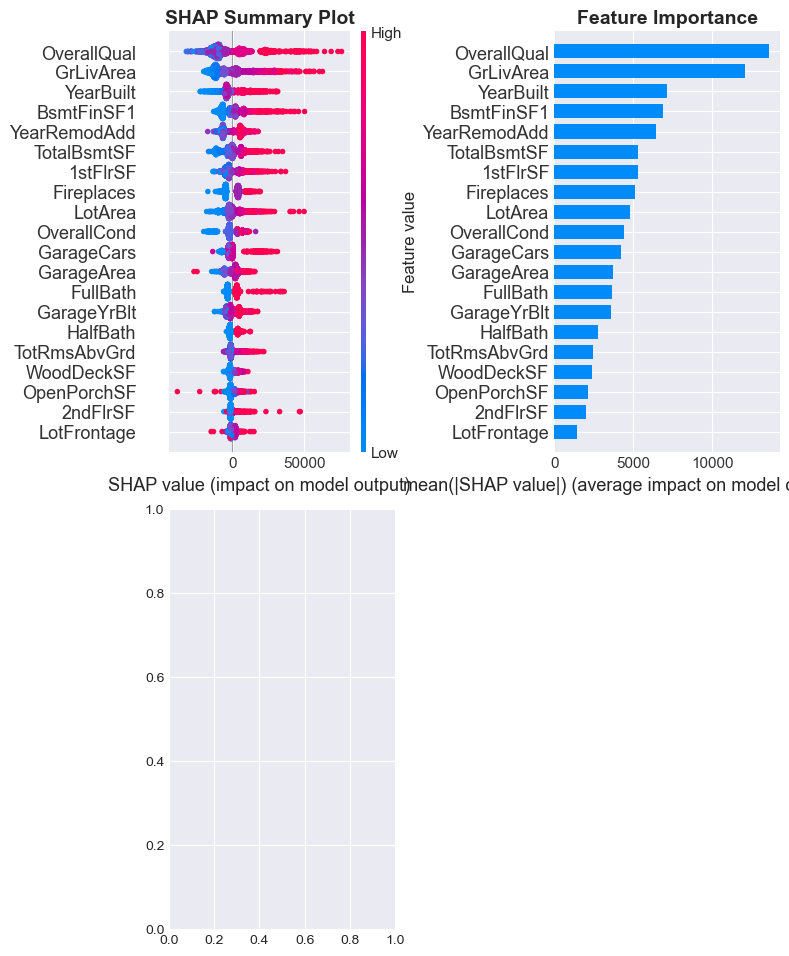

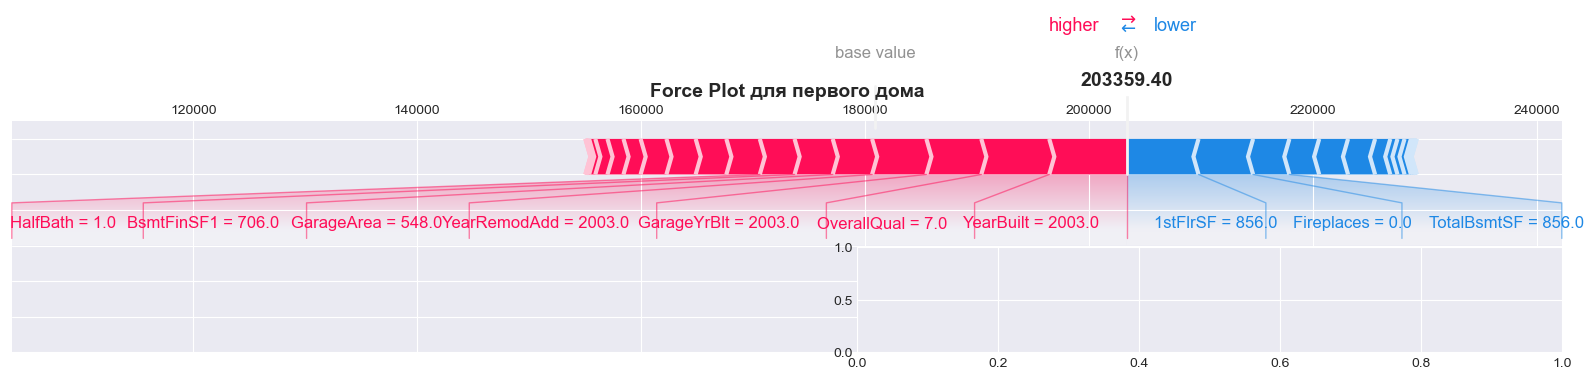

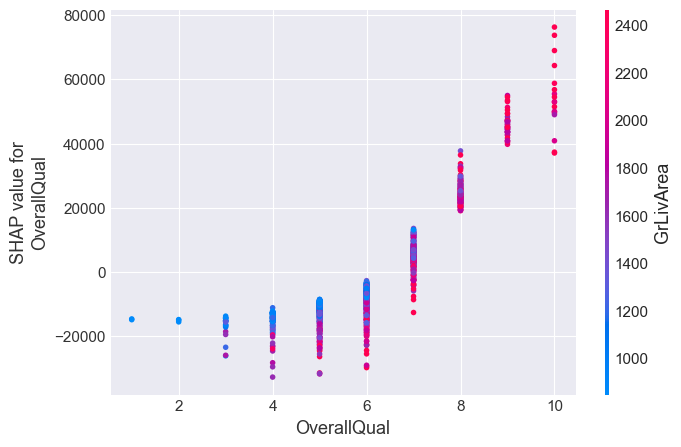

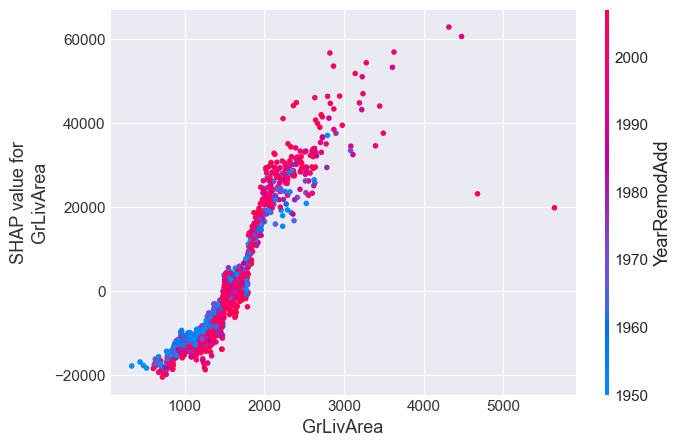

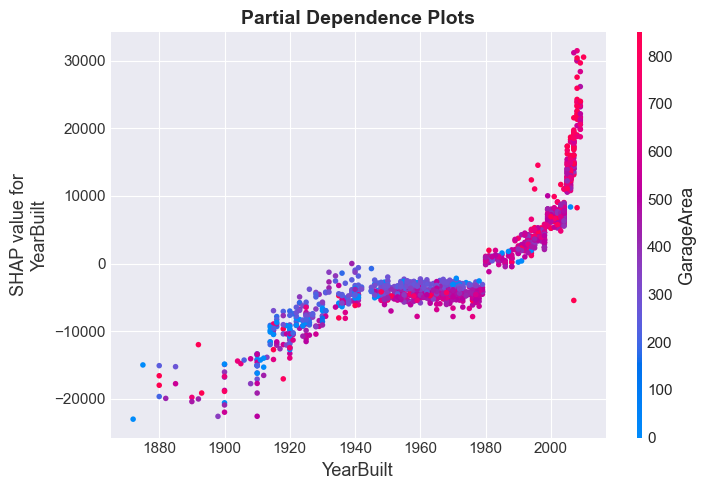

5. Анализ результатов...
\n🎯 Топ-10 самых важных признаков по SHAP:
 4. OverallQual               | Важность: 13599.1507
16. GrLivArea                 | Важность: 12084.9951
 6. YearBuilt                 | Важность: 7109.1309
 9. BsmtFinSF1                | Важность: 6910.8778
 7. YearRemodAdd              | Важность: 6437.3008
12. TotalBsmtSF               | Важность: 5310.1731
13. 1stFlrSF                  | Важность: 5304.8789
24. Fireplaces                | Важность: 5136.9660
 3. LotArea                   | Важность: 4770.0537
 5. OverallCond               | Важность: 4400.3509
\n6. Предсказания на тестовых данных...
✅ Submission создан: submission_catboost.csv
   Статистика:
   • Среднее: $178,619
   • Медиана: $158,696
   • Не-zero признаков: 36


In [39]:
# Подготовка данных
print("1. Подготовка данных...")

# Берем числовые признаки (CatBoost может работать с категориальными, 
# но для SHAP проще начать с числовых)
X_num = X_train_processed.select_dtypes(include=[np.number]).copy()

# Удаляем Id и SalePrice из признаков
if 'Id' in X_num.columns:
    X_num = X_num.drop('Id', axis=1)
if 'SalePrice' in X_num.columns:
    y_num = X_num['SalePrice'].copy()
    X_num = X_num.drop('SalePrice', axis=1)
else:
    y_num = X_train_processed['SalePrice'].copy()

print(f"   X_num shape: {X_num.shape}")
print(f"   y_num shape: {y_num.shape}")

# Заполняем пропуски
X_num = X_num.fillna(X_num.median())

# 2. Обучение CatBoost
print("2. Обучение CatBoost...")

model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    random_seed=123,
    verbose=False
)


model.fit(X_num, y_num, plot=True)
print(f"✅ CatBoost обучен! R²: {model.score(X_num, y_num):.4f}")

# 3. SHAP анализ
print("3. SHAP анализ...")

# Создаем объяснитель
explainer = shap.TreeExplainer(model)

# Вычисляем SHAP значения (может занять время)
print("   Вычисление SHAP значений...")
shap_values = explainer.shap_values(X_num)

print(f"   SHAP значения вычислены. Размер: {shap_values.shape}")

# 4. Визуализация
print("4. Визуализация результатов...")

# Создаем фигуру
fig = plt.figure(figsize=(16, 10))

# График 1: Summary plot
ax1 = plt.subplot(2, 2, 1)
shap.summary_plot(shap_values, X_num, show=False)
plt.title("SHAP Summary Plot", fontsize=14, fontweight='bold')

# График 2: Bar plot (важность признаков)
ax2 = plt.subplot(2, 2, 2)
shap.summary_plot(shap_values, X_num, plot_type="bar", show=False)
plt.title("Feature Importance", fontsize=14, fontweight='bold')

# График 3: Force plot для первого наблюдения
ax3 = plt.subplot(2, 2, 3)
shap.force_plot(explainer.expected_value, shap_values[0, :], 
                X_num.iloc[0, :], matplotlib=True, show=False)
plt.title(f"Force Plot для первого дома", fontsize=14, fontweight='bold')

# График 4: Зависимости для топ-3 признаков
ax4 = plt.subplot(2, 2, 4)
# Находим топ-3 признака по важности
feature_importance = np.abs(shap_values).mean(axis=0)
top_features_idx = np.argsort(feature_importance)[-3:][::-1]
top_features = X_num.columns[top_features_idx]

for i, feature in enumerate(top_features):
    shap.dependence_plot(feature, shap_values, X_num, show=False)
    
plt.title("Partial Dependence Plots", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 5. Анализ результатов
print("5. Анализ результатов...")

# Важность признаков
importance_df = pd.DataFrame({
    'feature': X_num.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

print("\\n🎯 Топ-10 самых важных признаков по SHAP:")
print("=" * 50)
for i, row in importance_df.head(10).iterrows():
    print(f"{i+1:2}. {row['feature']:25} | Важность: {row['importance']:.4f}")

# 6. Предсказания на тесте
print("\\n6. Предсказания на тестовых данных...")

# Подготовка тестовых данных
X_test_num = X_test_processed.select_dtypes(include=[np.number]).copy()
if 'Id' in X_test_num.columns:
    X_test_num = X_test_num.drop('Id', axis=1)

# Заполняем пропуски
X_test_num = X_test_num.fillna(X_num.median())  # Используем медианы из train

# Предсказания
y_test_pred = model.predict(X_test_num)

# Создание submission
submission_catboost = pd.DataFrame({
    'Id': X_test_processed['Id'],
    'SalePrice': y_test_pred
})

# Обрезаем выбросы
q99 = submission_catboost['SalePrice'].quantile(0.99)
submission_catboost['SalePrice'] = submission_catboost['SalePrice'].clip(upper=q99)

# Сохраняем
submission_file = 'submission_catboost.csv'
submission_catboost.to_csv(submission_file, index=False)

print(f"✅ Submission создан: {submission_file}")
print(f"   Статистика:")
print(f"   • Среднее: ${submission_catboost['SalePrice'].mean():,.0f}")
print(f"   • Медиана: ${submission_catboost['SalePrice'].median():,.0f}")
print(f"   • Не-zero признаков: {len(importance_df[importance_df['importance'] > 0])}")


In [ ]:
# 1. РЕМОНТ
train_data['IsOldNotRemod'] = ((train_data['HouseAge'] > 50) & 
                              (train_data['RemodAge'] == train_data['HouseAge'])).astype(int)
test_data['IsOldNotRemod'] = ((test_data['HouseAge'] > 50) & 
                             (test_data['RemodAge'] == test_data['HouseAge'])).astype(int)



#Качество × площадь = OverallQual × GrLivArea.

train_data['QualCondDiff'] = train_data['OverallQual'] - train_data['OverallCond']
test_data['QualCondDiff'] = test_data['OverallQual'] - test_data['OverallCond']



# 12. ЕСТЬ ГАРАЖ (бинарная фича)
train_data['HasGarage'] = (train_data['GarageArea'] > 0).astype(int)
test_data['HasGarage'] = (test_data['GarageArea'] > 0).astype(int)

# 13. ЕСТЬ ПОДВАЛ
train_data['HasBsmt'] = (train_data['TotalBsmtSF'] > 0).astype(int)
test_data['HasBsmt'] = (test_data['TotalBsmtSF'] > 0).astype(int)

# 14. ПЛОЩАДЬ УЧАСТКА НА ПЛОЩАДЬ ДОМА
train_data['LotRatio'] = train_data['LotArea'] / train_data['GrLivArea']
test_data['LotRatio'] = test_data['LotArea'] / test_data['GrLivArea']
train_data['LotRatio'] = train_data['LotRatio'].replace([np.inf, -np.inf], 0)
test_data['LotRatio'] = test_data['LotRatio'].replace([np.inf, -np.inf], 0)